In [1]:
# Essential imports
import numpy as np
import pandas as pd
from pandas import read_csv, DataFrame
from matplotlib import pyplot as plt

In [3]:
from google.colab import files
upload = files.upload()

Saving housing.csv to housing.csv


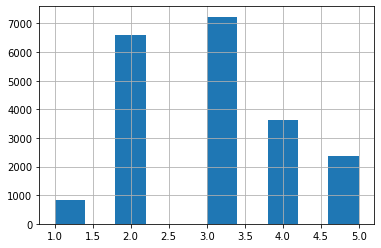

In [4]:
# Reading the dataset
housing=read_csv("housing.csv")
housing['income_cat'] = pd.cut(housing['median_income'], bins = [0, 1.5, 3, 4.5, 6, np.inf], labels=[1, 2, 3, 4, 5])
housing['income_cat'].hist()

In [5]:
# Stratified shuffle split beacuase the dataset is not shuffled
# We may have a bad dataset if we not shuffle the dataset
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [6]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis = 1, inplace= True)

In [7]:
# Dropping the labels
housing = strat_train_set.drop('median_house_value', axis =1)
# Taking the labels
housing_labels = strat_train_set['median_house_value'].copy()

In [8]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
housing_num = housing.drop('ocean_proximity',axis=1)
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [9]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [10]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [11]:
(imputer.statistics_ == housing_num.median().values).all()

True

In [12]:
X = imputer.transform(housing_num)
housing_tr = DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [13]:
# Handling Text and Categorical Attribute
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [14]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [15]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [16]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [17]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [18]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [19]:
# Making coustom transformers
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

In [20]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):        #no *argsor **kargs required
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        bedrooms_per_rooms = X[:, bedrooms_ix] / X[:, rooms_ix]
        if self.add_bedrooms_per_room:
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_rooms]
        else:
            return np.c_[X, rooms_per_household,  population_per_household, bedrooms_per_rooms]

In [21]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [23]:
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('arrtribs_adder', CombinedAttributesAdder()), ('std_scaler', StandardScaler())])

In [24]:
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [25]:
from sklearn.compose import ColumnTransformer

In [26]:
num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

In [27]:
full_pipeline = ColumnTransformer([('num', num_pipeline, num_attribs), ('cat', OneHotEncoder(), cat_attribs)])

In [28]:
housing_prepared = full_pipeline.fit_transform(housing)

In [29]:
# Select and Train Model
from sklearn.linear_model import LinearRegression

In [30]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)
# lin_reg.fit()

LinearRegression()

In [31]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions : ", lin_reg.predict(some_data_prepared))

Predictions :  [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]


In [32]:
print("Labels : ", list(some_labels))

Labels :  [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [33]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

In [34]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [35]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [36]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring = "neg_mean_squared_error", cv=10)

In [37]:
tree_rmse_scores = np.sqrt(-scores)

In [38]:
def display_scores(scores):
    print("Scores : ",scores)
    print("Mean : ",scores.mean())
    print("Standard deviation : ",scores.std())

In [39]:
display_scores(tree_rmse_scores)

Scores :  [72365.72419772 70602.81328748 69056.20579717 71100.40611279
 70122.27760586 78403.48169507 70555.97562727 73520.4973387
 66733.43642468 70160.238117  ]
Mean :  71262.1056203741
Standard deviation :  2935.390104359885


In [40]:
lin_score = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)

In [41]:
lin_rmse_scores = np.sqrt(-lin_score)
display_scores(lin_rmse_scores)

Scores :  [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean :  69104.07998247063
Standard deviation :  2880.3282098180644


In [42]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [43]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)

In [44]:
print(forest_rmse.mean())
print()
display_scores(forest_rmse)

18447.210184478194

Scores :  18447.210184478194
Mean :  18447.210184478194
Standard deviation :  0.0


In [45]:
scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_score = np.sqrt(-scores)

In [46]:
display_scores(forest_rmse_score)

Scores :  [51474.03789742 48997.15716772 46562.28613703 51966.44560063
 47635.10318149 51966.88989658 52511.64475825 49746.08553949
 48474.61952964 54112.05272006]
Mean :  50344.63224283162
Standard deviation :  2296.6397294631456


In [47]:
# Fine Tune the Model

In [48]:
from sklearn.model_selection import GridSearchCV

In [49]:
param_grid = [{'n_estimators':[3, 10, 30], 'max_features':[2, 4, 6, 8]},{'bootstrap':[False],'n_estimators':[3, 10], 'max_features':[2, 3, 4]},]

In [50]:
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring = 'neg_mean_squared_error', return_train_score=True)

In [51]:
grid_search.fit(housing_prepared, housing_labels)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [52]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [53]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [54]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

64126.55436021155 {'max_features': 2, 'n_estimators': 3}
55622.51057707401 {'max_features': 2, 'n_estimators': 10}
52747.63687676527 {'max_features': 2, 'n_estimators': 30}
59655.73265798717 {'max_features': 4, 'n_estimators': 3}
52365.642263125956 {'max_features': 4, 'n_estimators': 10}
50476.132437770095 {'max_features': 4, 'n_estimators': 30}
59168.75488022049 {'max_features': 6, 'n_estimators': 3}
52139.732721037726 {'max_features': 6, 'n_estimators': 10}
50210.852905387015 {'max_features': 6, 'n_estimators': 30}
59526.638156138826 {'max_features': 8, 'n_estimators': 3}
52477.453244987824 {'max_features': 8, 'n_estimators': 10}
50219.99084598658 {'max_features': 8, 'n_estimators': 30}
62761.42420500822 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54471.00729236182 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60579.6758514309 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52218.80874848371 {'bootstrap': False, 'max_features': 3, 'n_estimators

In [55]:
feature_importance = grid_search.best_estimator_.feature_importances_

In [56]:
feature_importance

array([8.72102881e-02, 7.77742864e-02, 3.91608210e-02, 1.75753442e-02,
       1.62712553e-02, 1.80188099e-02, 1.67533309e-02, 3.15426636e-01,
       5.42242746e-02, 1.05598614e-01, 8.16367144e-02, 1.02467129e-02,
       1.53250458e-01, 9.23339268e-05, 3.36070935e-03, 3.39941174e-03])

In [57]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_rooms']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importance, attributes), reverse=True)

[(0.3154266355457757, 'median_income'),
 (0.15325045813375154, 'INLAND'),
 (0.10559861365688938, 'pop_per_hhold'),
 (0.08721028807548217, 'longitude'),
 (0.08163671443906088, 'bedrooms_per_rooms'),
 (0.07777428644069044, 'latitude'),
 (0.054224274555522985, 'rooms_per_hhold'),
 (0.03916082097016518, 'housing_median_age'),
 (0.018018809852352123, 'population'),
 (0.01757534416612955, 'total_rooms'),
 (0.016753330872133838, 'households'),
 (0.016271255341818235, 'total_bedrooms'),
 (0.010246712936096528, '<1H OCEAN'),
 (0.0033994117369818403, 'NEAR OCEAN'),
 (0.0033607093503598257, 'NEAR BAY'),
 (9.233392678977222e-05, 'ISLAND')]

In [58]:
# Evaluate Your System on Test Set
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()
X_test_prepared = full_pipeline.transform(X_test)
final_prediction = final_model.predict(X_test_prepared)

In [60]:
final_mse = mean_squared_error(y_test, final_prediction)
final_rmse = np.sqrt(final_mse)
final_rmse

47429.57992717467